DTSA 5509 Supervised Learning Final Project

Predictive System for Handling ELectrical Faults

The Electrical Power Grid has grown substantially over the years, integrating a number of small-scale distributed energy resources such as solar photovoltaics and electrical vehicles have been very beneficial in meeting our energy demands. 
However, due to their intrinsic variability, uncertainty, and limited controllability, these new assets and technologies bring new challenges to the reliable and secure operations of electric distribution networks. Increasing numbers of DERs are exposing the limitations of existing analytical tools for operating and managing electric distribution networks, primarily because these tools were designed for traditional distribution networks wherein uncertainty arises only from the consumption profiles, and power is supplied predominantly from the transmission system to the distribution system.
The aim of this sytem is to apply ML techniques and algorithms to analyze the operation of modern electric distribution networks to assist in the classification and identification of elctrical faults, also being able to predict said faults before they happen keeping the grid safer, more economical and more reliable.

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

In [3]:
#Loads data set
data = pd.read_csv('classData.csv')

The dataset, classData.csv, was gotten from a simulating a power system using matlab credits to E Sathya Prakash on kaggle. It includes data points for line voltages and line currents under various operational and fault conditions. The key features and their descriptions are as follows:

Current in Line A (Ia)
Current in Line B (Ib)
Current in Line C (Ic)
Voltage in Line A (Va)
Voltage in Line B (Vb)
Voltage in Line C (Vc)

The dataset also includes labels indicating different types of faults in a binary format, corresponding to various fault conditions in the transmission line.


In [4]:
#first few rows of dataset
data.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983


In [5]:
#Cleaning the dataset
#drops any null/missing values
data.dropna(inplace=True)

# Checking for any duplicates
duplicate_rows = data.duplicated().sum()

duplicate_rows

0

In [6]:
# Converting the fault indicator columns to a single label representing the type of fault
data['Fault_Type'] = data[['G', 'C', 'B', 'A']].astype(str).agg(''.join, axis=1)

# Defining the fault types
fault_types = {
    '0000': 'No Fault',
    '1000': 'Single Line to Ground A',
    '0100': 'Single Line to Ground B',
    '0010': 'Single Line to Ground C',
    '0011': 'Line-to-Line BC',
    '0101': 'Line-to-Line AC',
    '1001': 'Line-to-Line AB',
    '1010': 'Line-to-Line with Ground AB',
    '0101': 'Line-to-Line with Ground AC',
    '0110': 'Line-to-Line with Ground BC',
    '0111': 'Three-Phase',
    '1111': 'Three-Phase with Ground',
    '1011': 'Line A Line B to Ground Fault'
}

# Mapping fault type codes to fault type names
data['Fault_Type'] = data['Fault_Type'].map(fault_types)

# Counting the occurrences of each fault type
fault_type_counts = data['Fault_Type'].value_counts()
fault_type_counts

Fault_Type
No Fault                         2365
Line A Line B to Ground Fault    1134
Three-Phase with Ground          1133
Line-to-Line AB                  1129
Three-Phase                      1096
Line-to-Line with Ground BC      1004
Name: count, dtype: int64

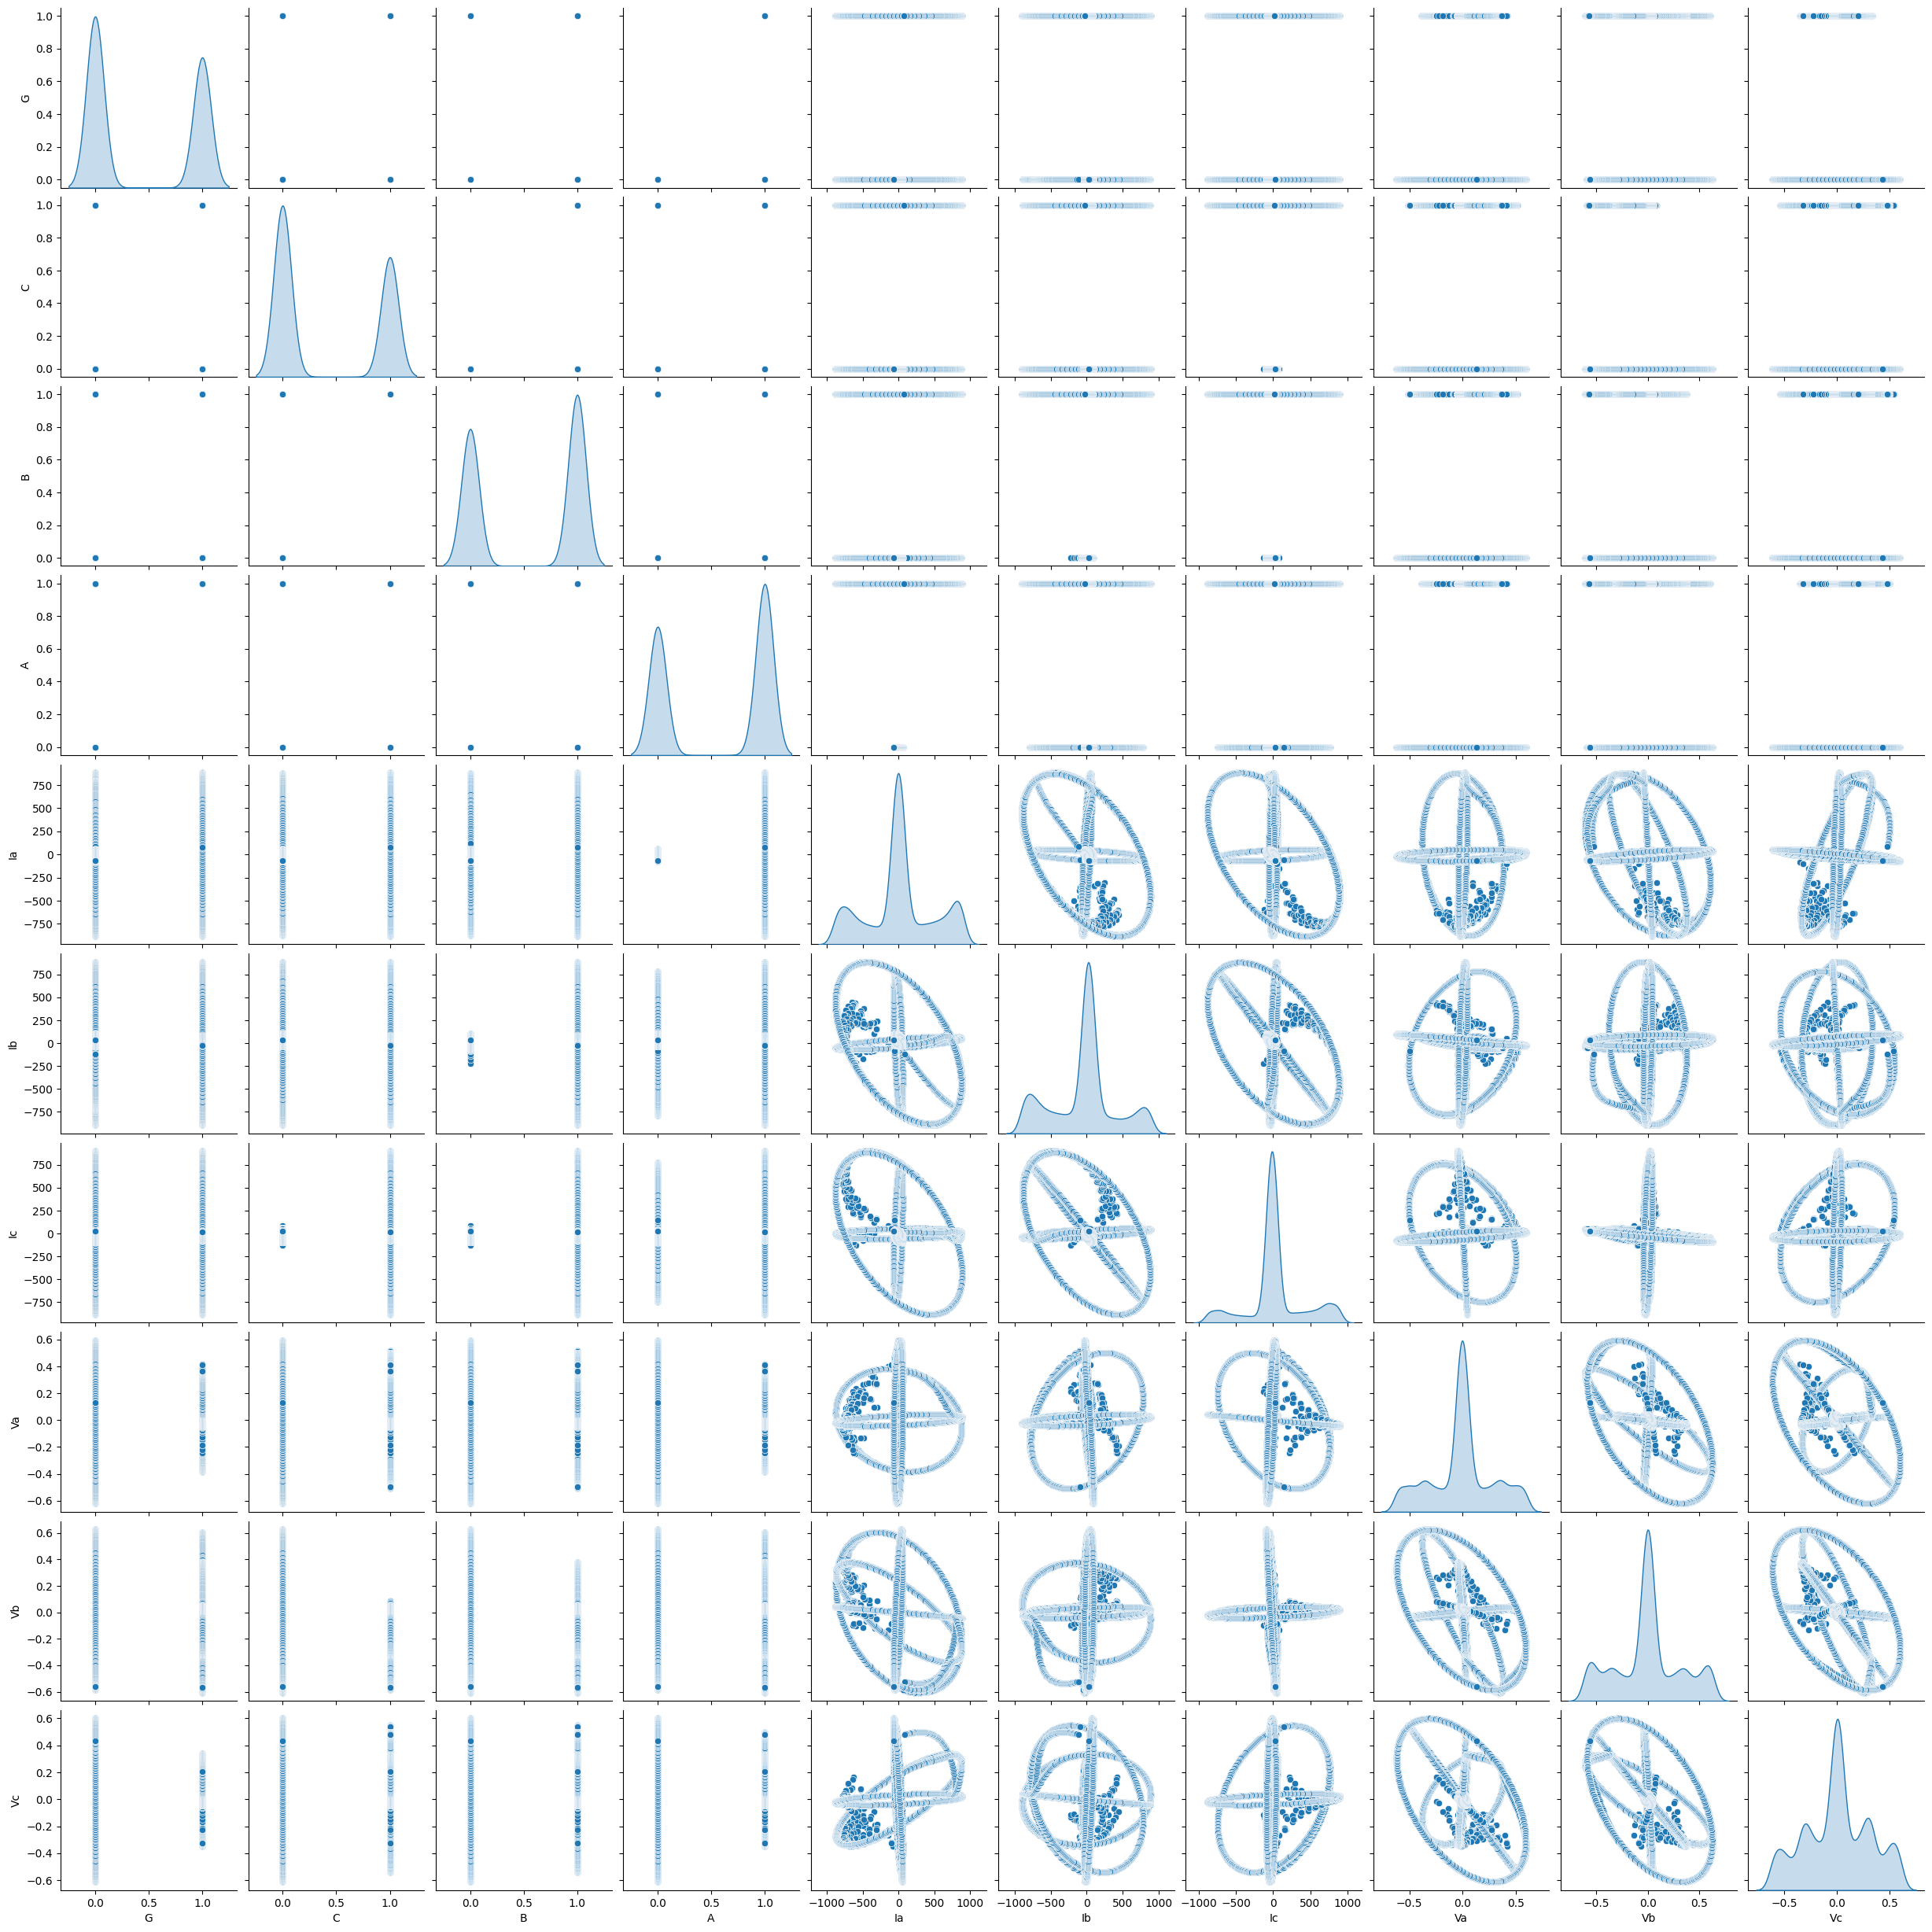

In [7]:
# inspecting relationships between features using a pair plot. 

columns = data.iloc[:,]

# Create a pair plot with KDE plots on the diagonal
sns.pairplot(columns, diag_kind='kde')

# Show the plot
plt.show()

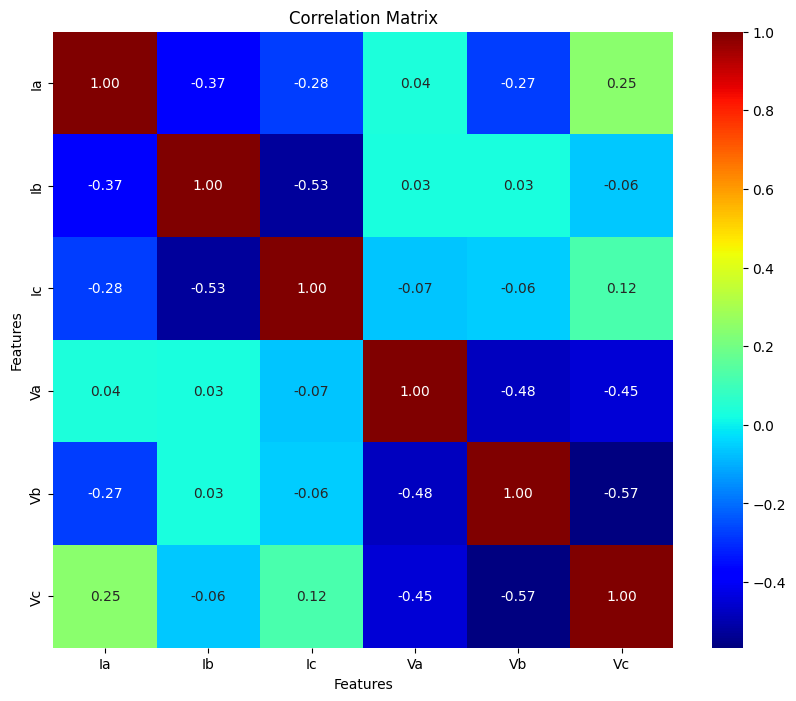

In [8]:
# visualizing correlation matrix using a heatmap
features = ['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc']
fig, ax = plt.subplots(figsize=(10, 8)) #larger subplot

sns.heatmap(data[features].corr(), annot=True, cmap='jet', fmt=".2f", linewidths=0, ax=ax)

plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Matrix')

# Show the plot
plt.show()

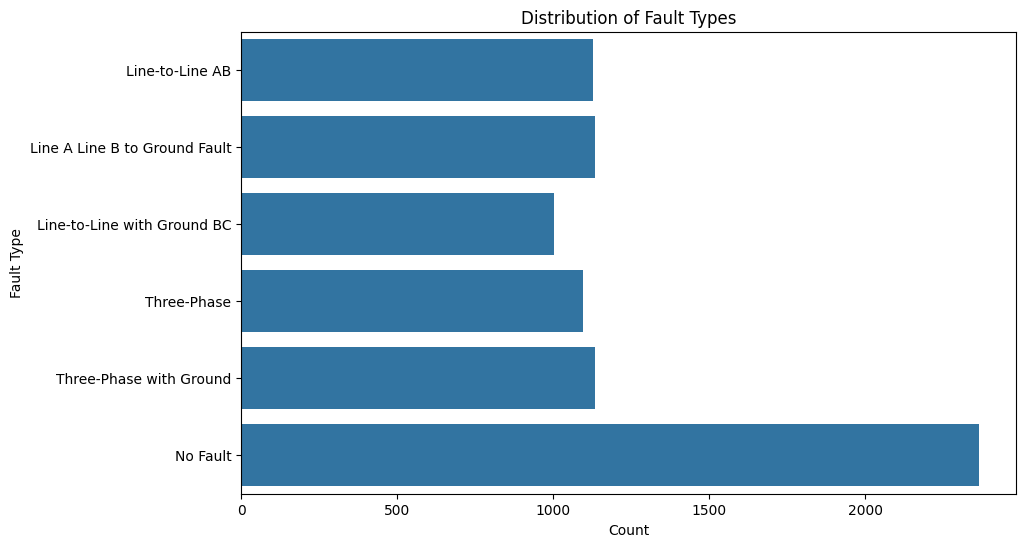

In [9]:
# Plotting the distribution of fault types
plt.figure(figsize=(10, 6))
sns.countplot(y=data['Fault_Type'])
plt.title('Distribution of Fault Types')
plt.xlabel('Count')
plt.ylabel('Fault Type')
plt.show()

In [10]:
# Normalization 
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[features])

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder and transform the 'Fault_Type' to integer labels
y_encoded = label_encoder.fit_transform(data['Fault_Type'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6288, 6), (1573, 6), (6288,), (1573,))

In [15]:
# Define a dictionary to store the cross-validation metrics of the algorithms
cv_metrics = {'Model': [], 'Accuracy': []}
test_metrics = {'Model': [], 'Accuracy': []}

# Define a function to train and evaluate each algorithm
def train_and_evaluate_model(model, model_name, X_train, y_train):
    # Define the scoring metrics for multi-class classification
    scoring = {
        'accuracy': make_scorer(accuracy_score),

    }

    # Perform cross-validation using StratifiedKFold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_validate(model, X_train, y_train, cv=skf, scoring=scoring)
    
    # Store the cross-validation metrics
    cv_metrics['Model'].append(model_name)
    cv_metrics['Accuracy'].append(scores['test_accuracy'].mean())
    print(f"{model_name}: Cross-validation metrics calculated")
    
    # Fit the model on the entire training set
    model.fit(X_train, y_train)
    return model

# Define a function to evaluate the model on the test set and store the metrics
def evaluate_on_test_set(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    test_metrics['Model'].append(model_name)
    test_metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
    print(f"{model_name}: Test metrics calculated")

# Train and evaluate each algorithm
models = [
    (LogisticRegression(random_state=42, max_iter=1000), "Logistic Regression"),
    (SVC(random_state=42), "Support Vector Machines"),
    (KNeighborsClassifier(), "K-Nearest Neighbors"),
    (DecisionTreeClassifier(random_state=42), "Decision Trees"),
    (RandomForestClassifier(random_state=42), "Random Forest"),
    (GaussianNB(), "Naive Bayes"),
    (AdaBoostClassifier(random_state=42), "AdaBoost"),
]

# Train and evaluate each model
for model, model_name in models:
    fitted_model = train_and_evaluate_model(model, model_name, X_train, y_train)
    evaluate_on_test_set(fitted_model, model_name, X_test, y_test)

# Convert the dictionary of cross-validation metrics to a DataFrame
cv_metrics_df = pd.DataFrame(cv_metrics)
test_metrics_df = pd.DataFrame(test_metrics)
print("\nCross-validation Metrics:")
print(cv_metrics_df)
print("\nTest Metrics:")
print(test_metrics_df)

Logistic Regression: Cross-validation metrics calculated
Logistic Regression: Test metrics calculated
Support Vector Machines: Cross-validation metrics calculated
Support Vector Machines: Test metrics calculated
K-Nearest Neighbors: Cross-validation metrics calculated
K-Nearest Neighbors: Test metrics calculated
Decision Trees: Cross-validation metrics calculated
Decision Trees: Test metrics calculated
Random Forest: Cross-validation metrics calculated
Random Forest: Test metrics calculated
Naive Bayes: Cross-validation metrics calculated
Naive Bayes: Test metrics calculated


C:\Users\olagu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\olagu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\olagu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this war

AdaBoost: Cross-validation metrics calculated


C:\Users\olagu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost: Test metrics calculated

Cross-validation Metrics:
                     Model  Accuracy
0      Logistic Regression  0.338106
1  Support Vector Machines  0.807252
2      K-Nearest Neighbors  0.829675
3           Decision Trees  0.863392
4            Random Forest  0.859733
5              Naive Bayes  0.795800
6                 AdaBoost  0.619274

Test Metrics:
                     Model  Accuracy
0      Logistic Regression  0.345836
1  Support Vector Machines  0.817546
2      K-Nearest Neighbors  0.804196
3           Decision Trees  0.886205
4            Random Forest  0.879212
5              Naive Bayes  0.794660
6                 AdaBoost  0.773681


Decision Tree Classifier

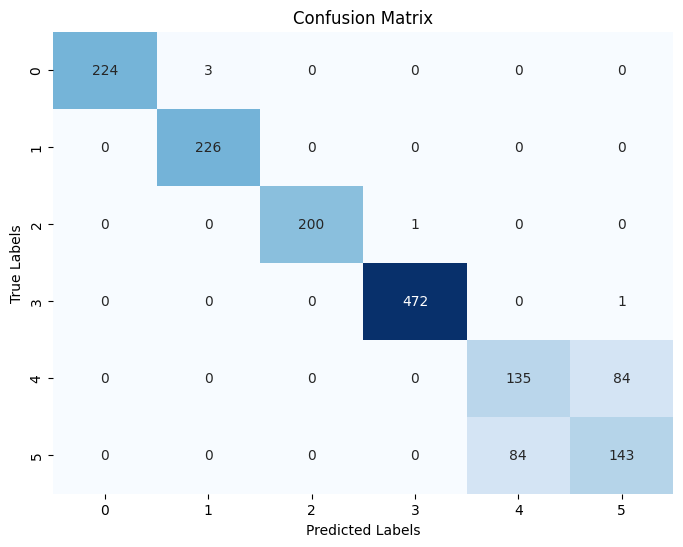

In [26]:
decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_dec)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

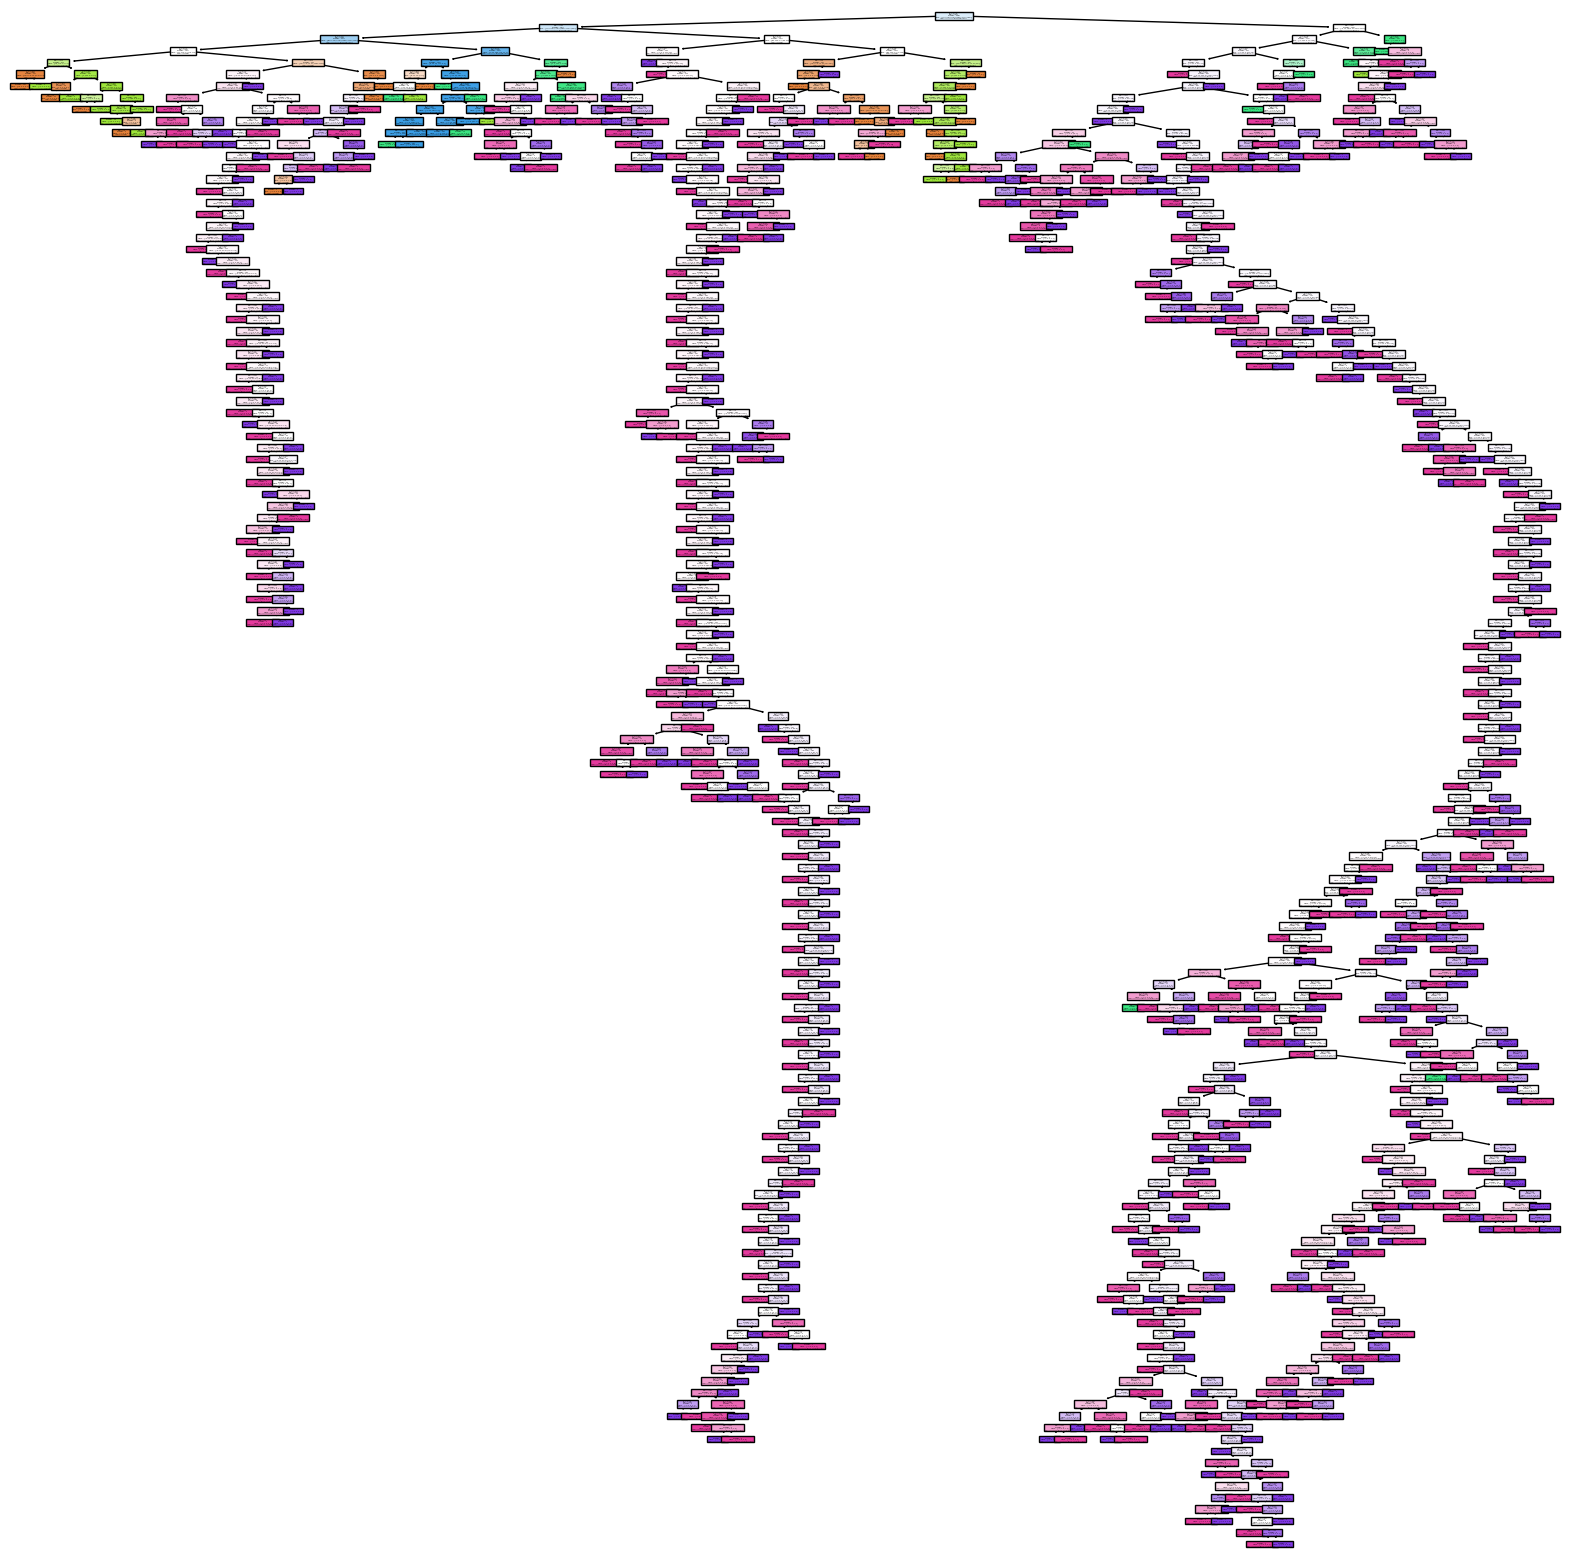

In [29]:
from sklearn import tree
def tree_plot(model_name):
    plt.figure(figsize=(20,20))
    features = data.columns
    classes = ['NO Fault','Line A to Ground Fault','Line B to Line C Fault','Line A Line B to Ground Fault','Line A Line B Line C','Line A Line B Line C to Ground Fault']
    tree.plot_tree(model_name,feature_names=features,class_names=classes,filled=True)
    plt.show()
tree_plot(decision)

Conclusion
    Decision tree algorithm proved to be most accurate ML algorithm to use with an accouracy of 88.9% however I fear this will not be accurate enough when predicting faults. In future iterations o fthe system there will be tuning of hyperparameters to ensure a success rate of closer to 100%.

This is evidence of the future of the usefulness Machine Learning algorithms in the power systems industry for predictive maintenaince, insights and exploratory data analysis. 